#### <b>Prepare Source Codes</b>

* Reference: https://github.com/genforce/interfacegan

In [ ]:
!git clone https://github.com/ndb796/interfacegan
%cd interfacegan

Cloning into 'interfacegan'...
remote: Enumerating objects: 247, done.
remote: Total 247 (delta 0), reused 0 (delta 0), pack-reused 247
Receiving objects: 100% (247/247), 11.39 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/interfacegan


#### <b>Prepare the Pre-trained StyleGAN Model</b>

* Reference: https://github.com/NVlabs/stylegan
* Load PyTorch model weights.

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EUGr2B_vVStNmoL8_Dr9bjEB3R71fqmw7GU1oqLVg_YNnA?download=1 -O ./models/pretrain/stylegan_celebahq.pth

--2021-03-14 16:21:02--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EUGr2B_vVStNmoL8_Dr9bjEB3R71fqmw7GU1oqLVg_YNnA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_celebahq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVUdyMkJfdlZTdE5tb0w4X0RyOWJqRUIzUjcxZnFtdzdHVTFvcUxWZ19ZTm5BP3J0aW1lPXE2WDlLUVhuMkVn [following]
--2021-03-14 16:21:03--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/StyleGAN/stylegan_celebahq.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FVUdyMkJfd

In [ ]:
from models.model_settings import MODEL_POOL

print(list(MODEL_POOL))

['pggan_celebahq', 'stylegan_celebahq', 'stylegan_ffhq']


#### <b>Load StyleGAN Model</b>

In [ ]:
import torch
from models.stylegan_generator import StyleGANGenerator


def normalized_to_normal_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 3, 1, 1).float()
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 3, 1, 1).float()
    
    image = image.detach().cpu()
    image *= std
    image += mean
    image *= 255
    
    image = image.numpy()
    image = np.transpose(image, (0, 2, 3, 1))

    return image.astype(np.uint8)


class PostSynthesisProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.min_value = -1
        self.max_value = 1

    def forward(self, synthesized_image):
        synthesized_image = (synthesized_image - self.min_value) * torch.tensor(255).float() / (self.max_value - self.min_value)
        synthesized_image = torch.clamp(synthesized_image + 0.5, min=0, max=255)

        return synthesized_image


synthesizer = StyleGANGenerator("stylegan_celebahq").model.synthesis
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)

[2021-03-14 16:21:11,799][INFO] Loading pytorch model from `models/pretrain/stylegan_celebahq.pth`.
[2021-03-14 16:21:12,114][INFO] Successfully loaded!
[2021-03-14 16:21:12,115][INFO]   `lod` of the loaded model is 0.0.


### <b>Dataset Download</b>

<pre>
<b>Dataset/</b>
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ET1JOEzWfFNInA923UV7Qm8BDxYKaEPTCJXzoHZ1dhjBOA?download=1 -O corrected_facial_identity_latent_vectors.zip
!unzip corrected_facial_identity_latent_vectors.zip -d ./corrected_facial_identity_latent_vectors

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [ ]:
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
# ref: https://chsasank.github.io/vision/_modules/torchvision/datasets/folder.html
from PIL import Image
import os
import os.path
from torch.utils.data import Dataset

EXTENSIONS = [
    '.npy',
]


def is_numpy_file(filename):
    return any(filename.endswith(extension) for extension in EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_numpy_file(fname):
                    path = os.path.join(root, fname).split('.npy')[0]
                    item = (path + '.png', path + '.npy', class_to_idx[target])
                    images.append(item)

    return images


def numpy_loader(path):
    return np.load(path)


def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


class LatentFolder(Dataset):
    def __init__(self, root, target_transforms):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.numpy_loader = numpy_loader
        self.pil_loader = pil_loader
        self.target_transforms = target_transforms

    def __getitem__(self, index):
        img, npy, target = self.imgs[index]
        img = self.pil_loader(img)
        img = self.target_transforms(img)
        npy = self.numpy_loader(npy)
        return img, npy, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
resizer = transforms.Compose([
    transforms.Resize((256, 256))
])
normalizer = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = './corrected_facial_identity_latent_vectors/corrected_facial_identity_latent_vectors'

test_dataset = LatentFolder(os.path.join(data_dir), transforms_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
print('Test dataset size:', len(test_dataset))

class_names = test_dataset.classes
print('Class names:', class_names)

Test dataset size: 191
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '223', '226', '228', '230', '

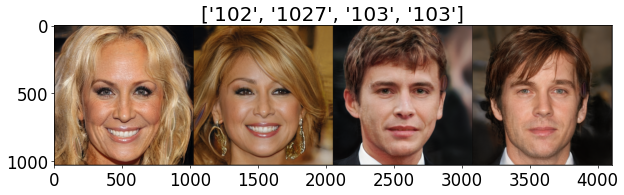

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(test_dataloader)

# visualize a batch of train image
inputs, npys, classes = next(iterator)

# Get predicted images
npys = torch.from_numpy(np.asarray(npys)).cuda()
with torch.no_grad():
    pred_images = synthesizer(npys)
    pred_images = post_processing(pred_images) / 255

out = torchvision.utils.make_grid(pred_images[:4]).cpu()
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Load Pre-trained Model</b>

In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1 -O facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth

--2021-03-14 16:21:28--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EeIlxtZtQIdFhRCUkCBSaIQBBbP5dujTUpRNtj8TRinRaQ?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth?originalPath=aHR0cHM6Ly9wb3N0ZWNoYWNrci1teS5zaGFyZXBvaW50LmNvbS86dTovZy9wZXJzb25hbC9kb25nYmlubmFfcG9zdGVjaF9hY19rci9FZUlseHRadFFJZEZoUkNVa0NCU2FJUUJCYlA1ZHVqVFVwUk50ajhUUmluUmFRP3J0aW1lPVVPampPQVhuMkVn [following]
--2021-03-14 16:21:28--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/CelebA%20HQ/facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth?

In [ ]:
save_path = 'facial_identity_classification_transfer_learning_with_ResNet18_resolution_256.pth'

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [ ]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    model
).to(device).eval()

### <b>Test Phase</b>

[Prediction Result Examples]


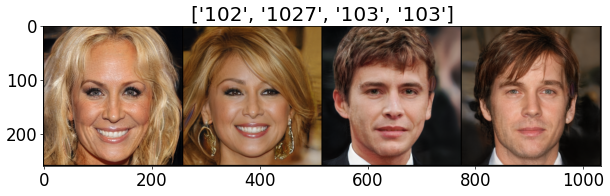

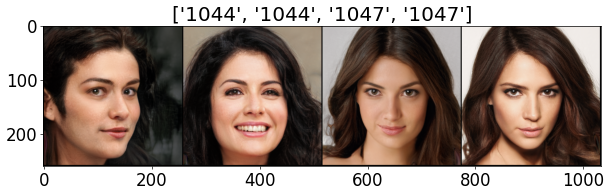

[Test] Loss: 0.5270 Acc: 100.0000% Time: 24.9162s


In [ ]:
criterion = nn.CrossEntropyLoss()

model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, npys, labels) in enumerate(test_dataloader):
        labels = labels.to(device)

        # Get predicted images
        npys = torch.from_numpy(np.asarray(npys)).cuda()
        with torch.no_grad():
            pred_images = synthesizer(npys)
            pred_images = resizer(post_processing(pred_images) / 255)

        outputs = model(pred_images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * pred_images.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(pred_images[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(pred_images[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#### <b>Prepare Adversarial Attack Libraries</b>

In [ ]:
!pip install foolbox
!pip install advertorch

In [ ]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example 1</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 100 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

In [ ]:
import random

random.seed(0)
np.random.seed(0)

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


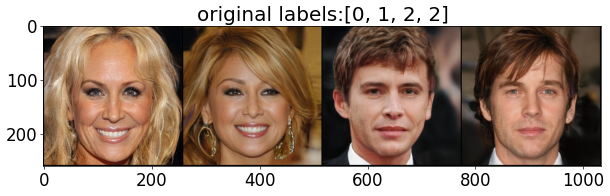

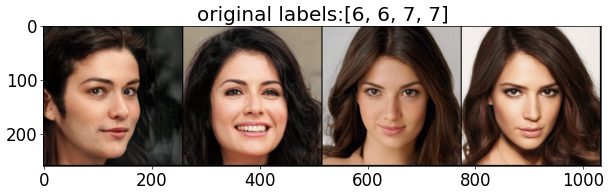

[Start Image Examples]


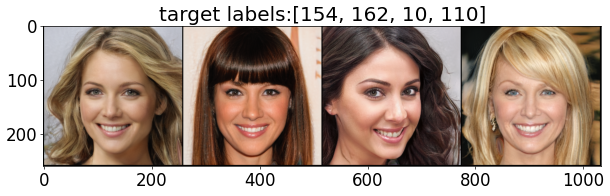

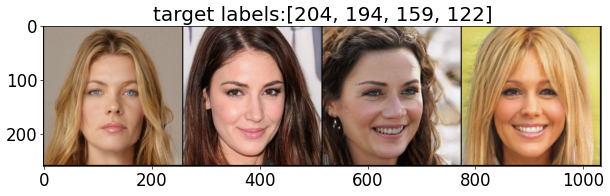

[Attack Result Examples]


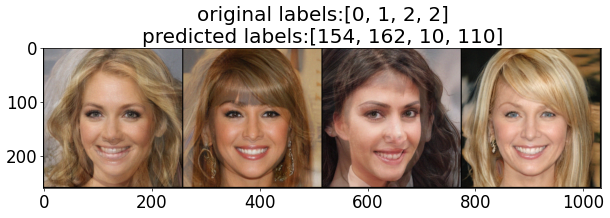

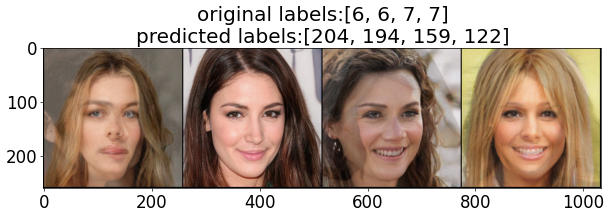

[Step #0] Loss: 1.1812 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3.8063s (total 8 images)
[Step #10] Loss: 1.1564 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 26.2388s (total 88 images)
[Step #20] Loss: 1.1359 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 49.2138s (total 168 images)
[Validation] Loss: 1.1303 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 55.8124s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196606.8115183246
Average L2 distance: 98.88628639101358
Average MSE: 0.054548890958905846
Average Linf distance (the maximum changed values): 0.6280006288857984


In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=100,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    labels = labels.to(device)

    # Get predicted images
    npys = torch.from_numpy(np.asarray(npys)).cuda()
    with torch.no_grad():
        pred_images = synthesizer(npys)
        pred_images = resizer(post_processing(pred_images) / 255)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        with torch.no_grad():
            npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
            pred_image = synthesizer(npy)
            pred_image = resizer(post_processing(pred_image) / 255)
            starting_points[k] = pred_image[0]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
            with torch.no_grad():
                npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
                pred_image = synthesizer(npy)
                pred_image = resizer(post_processing(pred_image) / 255)
                starting_points[k] = pred_image[0]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, pred_images, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, pred_images)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', pred_images.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(pred_images[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(pred_images[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 2</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 500 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


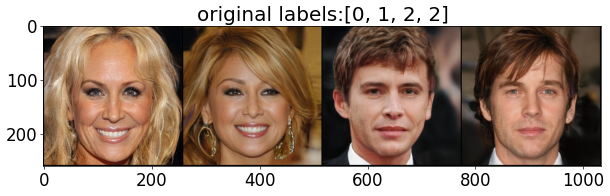

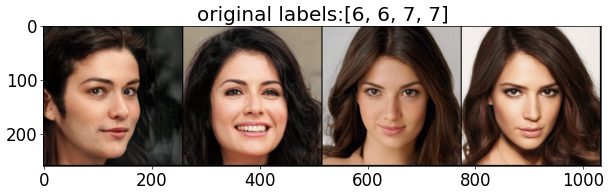

[Start Image Examples]


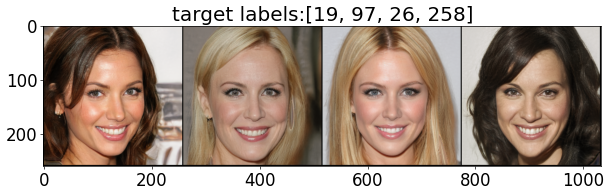

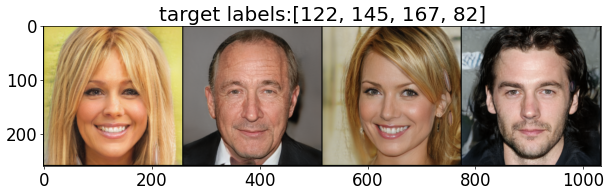

[Attack Result Examples]


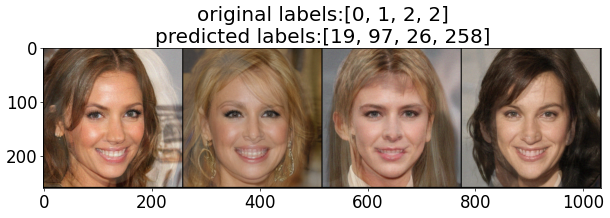

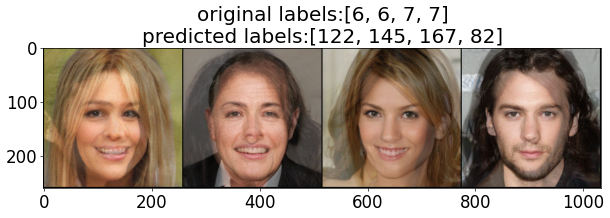

[Step #0] Loss: 1.0647 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 9.3039s (total 8 images)
[Step #10] Loss: 0.9310 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 86.4579s (total 88 images)
[Step #20] Loss: 0.9135 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 163.6462s (total 168 images)
[Validation] Loss: 0.9173 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 185.8839s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196606.18324607328
Average L2 distance: 86.14308925448913
Average MSE: 0.04211360489198675
Average Linf distance (the maximum changed values): 0.5458995821588326


In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=500,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    labels = labels.to(device)

    # Get predicted images
    npys = torch.from_numpy(np.asarray(npys)).cuda()
    with torch.no_grad():
        pred_images = synthesizer(npys)
        pred_images = resizer(post_processing(pred_images) / 255)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        with torch.no_grad():
            npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
            pred_image = synthesizer(npy)
            pred_image = resizer(post_processing(pred_image) / 255)
            starting_points[k] = pred_image[0]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
            with torch.no_grad():
                npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
                pred_image = synthesizer(npy)
                pred_image = resizer(post_processing(pred_image) / 255)
                starting_points[k] = pred_image[0]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, pred_images, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, pred_images)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', pred_images.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(pred_images[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(pred_images[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 3</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 1000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


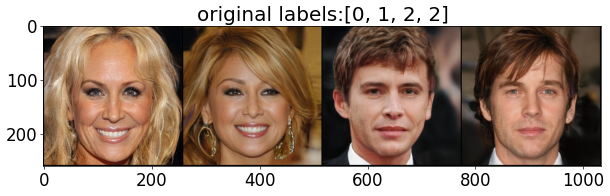

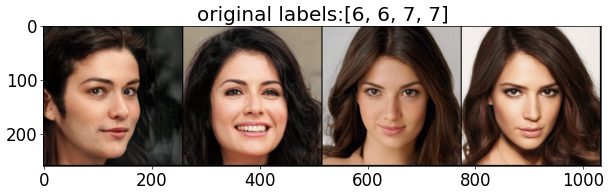

[Start Image Examples]


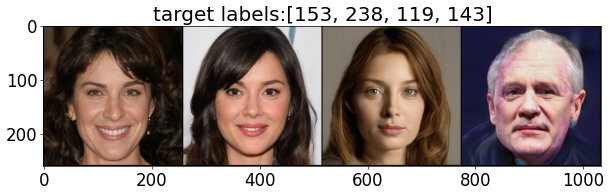

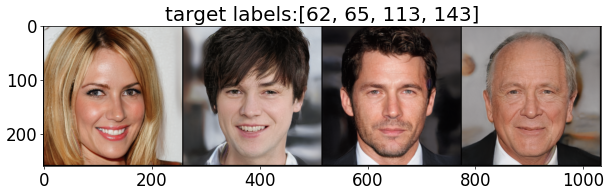

[Attack Result Examples]


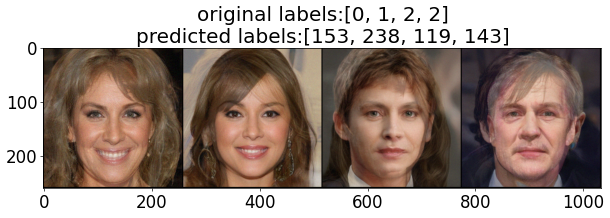

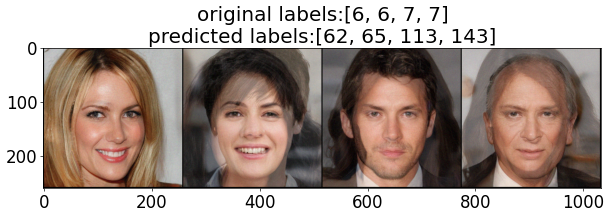

[Step #0] Loss: 0.8086 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 16.0637s (total 8 images)
[Step #10] Loss: 0.8281 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 161.7007s (total 88 images)
[Step #20] Loss: 0.8194 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 307.2869s (total 168 images)
[Validation] Loss: 0.8081 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 349.0492s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196607.6544502618
Average L2 distance: 78.57627860663449
Average MSE: 0.034273677237370875
Average Linf distance (the maximum changed values): 0.5077782476135574


In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=1000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    labels = labels.to(device)

    # Get predicted images
    npys = torch.from_numpy(np.asarray(npys)).cuda()
    with torch.no_grad():
        pred_images = synthesizer(npys)
        pred_images = resizer(post_processing(pred_images) / 255)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        with torch.no_grad():
            npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
            pred_image = synthesizer(npy)
            pred_image = resizer(post_processing(pred_image) / 255)
            starting_points[k] = pred_image[0]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
            with torch.no_grad():
                npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
                pred_image = synthesizer(npy)
                pred_image = resizer(post_processing(pred_image) / 255)
                starting_points[k] = pred_image[0]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, pred_images, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, pred_images)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', pred_images.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(pred_images[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(pred_images[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 4</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 3000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


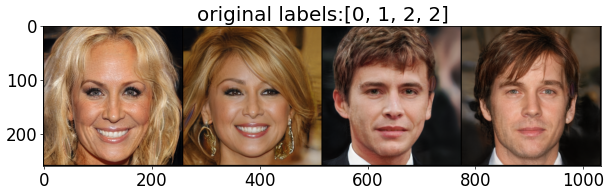

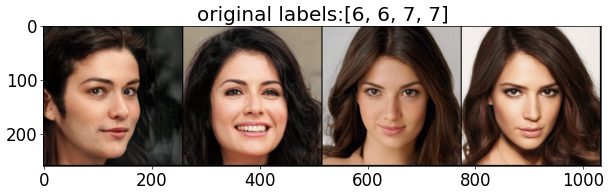

[Start Image Examples]


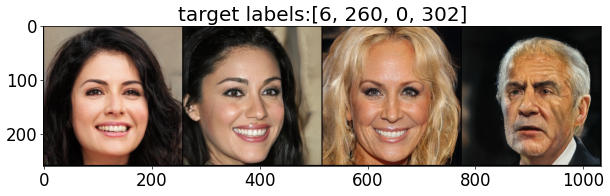

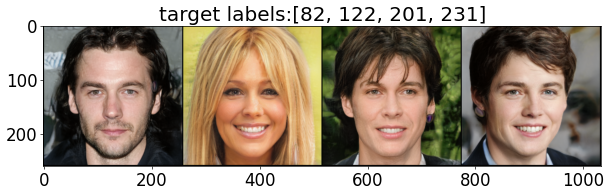

[Attack Result Examples]


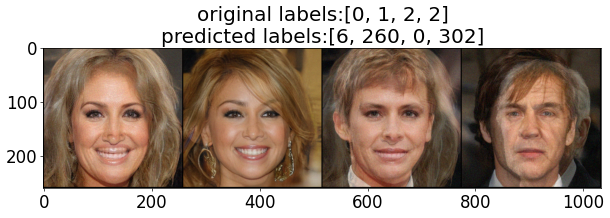

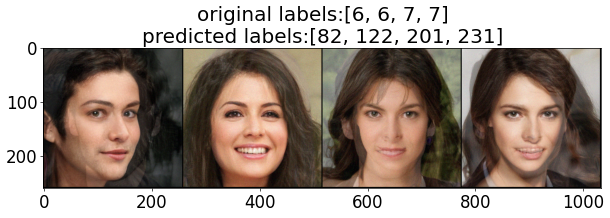

[Step #0] Loss: 0.5167 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 43.4403s (total 8 images)
[Step #10] Loss: 0.4587 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 462.7117s (total 88 images)
[Step #20] Loss: 0.4874 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 881.8074s (total 168 images)
[Validation] Loss: 0.4844 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 1002.0776s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196606.93717277487
Average L2 distance: 47.602101271065116
Average MSE: 0.013623428282313322
Average Linf distance (the maximum changed values): 0.33765460433760236


In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=3000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    labels = labels.to(device)

    # Get predicted images
    npys = torch.from_numpy(np.asarray(npys)).cuda()
    with torch.no_grad():
        pred_images = synthesizer(npys)
        pred_images = resizer(post_processing(pred_images) / 255)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        with torch.no_grad():
            npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
            pred_image = synthesizer(npy)
            pred_image = resizer(post_processing(pred_image) / 255)
            starting_points[k] = pred_image[0]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
            with torch.no_grad():
                npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
                pred_image = synthesizer(npy)
                pred_image = resizer(post_processing(pred_image) / 255)
                starting_points[k] = pred_image[0]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, pred_images, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, pred_images)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', pred_images.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(pred_images[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(pred_images[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 5</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 5000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


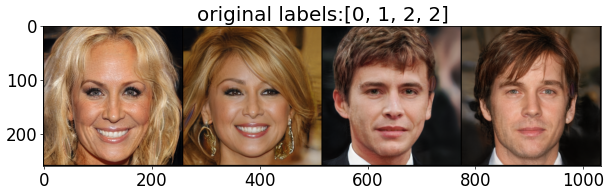

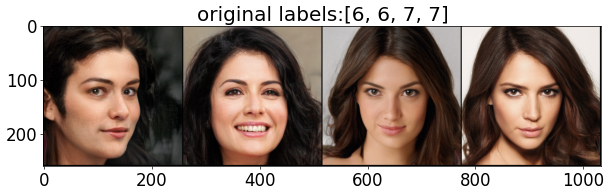

[Start Image Examples]


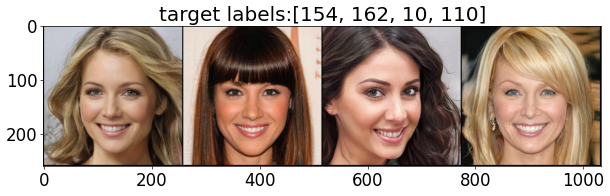

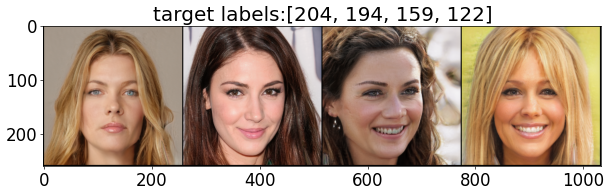

[Attack Result Examples]


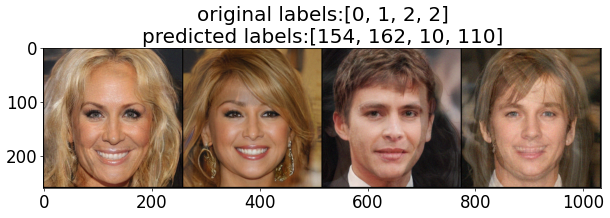

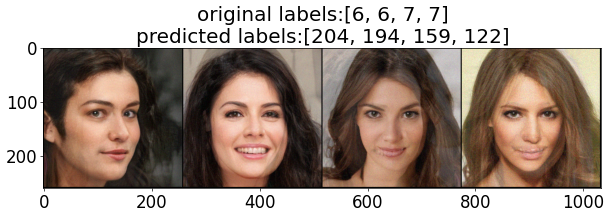

[Step #0] Loss: 0.4569 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 281.3403s (total 8 images)
[Step #10] Loss: 0.4714 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 3068.2897s (total 88 images)
[Step #20] Loss: 0.4533 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 5867.2827s (total 168 images)
[Validation] Loss: 0.4521 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 6702.0991s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196606.29319371728
Average L2 distance: 36.01850563568595
Average MSE: 0.008348642394960862
Average Linf distance (the maximum changed values): 0.26916559266794415


In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=5000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    labels = labels.to(device)

    # Get predicted images
    npys = torch.from_numpy(np.asarray(npys)).cuda()
    with torch.no_grad():
        pred_images = synthesizer(npys)
        pred_images = resizer(post_processing(pred_images) / 255)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        with torch.no_grad():
            npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
            pred_image = synthesizer(npy)
            pred_image = resizer(post_processing(pred_image) / 255)
            starting_points[k] = pred_image[0]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
            with torch.no_grad():
                npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
                pred_image = synthesizer(npy)
                pred_image = resizer(post_processing(pred_image) / 255)
                starting_points[k] = pred_image[0]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, pred_images, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, pred_images)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', pred_images.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(pred_images[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(pred_images[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)

#### <b>Adversarial Attack Example 6</b>

* <b>Attack method</b>: Boundary Attack
* <b>Options</b>: 10000 iterations + start from the target (targeted attack)
* <b>Images</b>: All test images

The dimension of an image tensor: torch.Size([3, 256, 256])
[Original Image Examples]


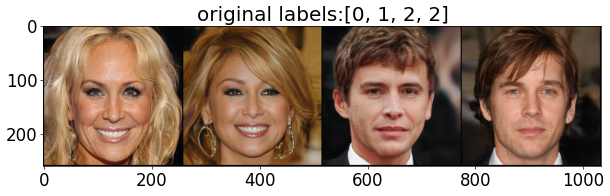

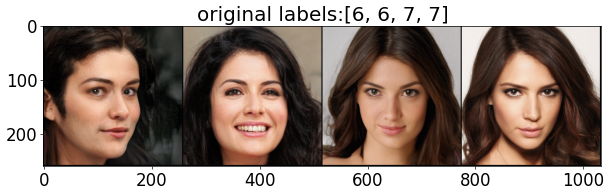

[Start Image Examples]


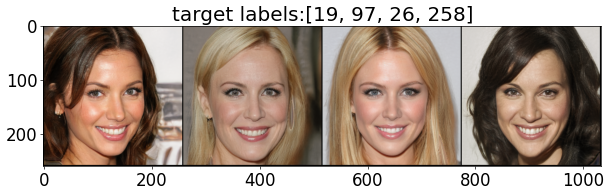

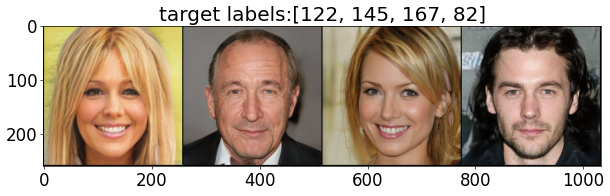

[Attack Result Examples]


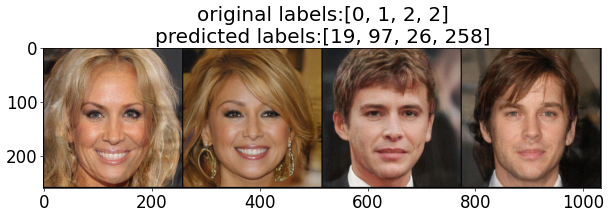

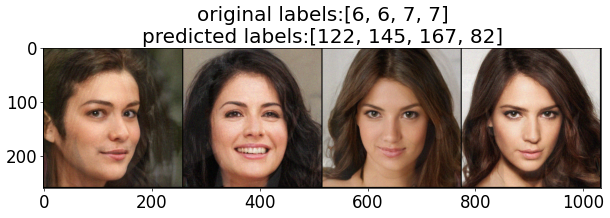

[Step #0] Loss: 0.4139 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 559.4602s (total 8 images)
[Step #10] Loss: 0.3683 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 6174.9150s (total 88 images)
[Step #20] Loss: 0.3820 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 11751.3736s (total 168 images)
[Validation] Loss: 0.3811 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 13410.1791s (total 191 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 196605.4659685864
Average L2 distance: 20.068787739539022
Average MSE: 0.0029227393362378576
Average Linf distance (the maximum changed values): 0.1611972557312531


In [ ]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.BoundaryAttack(init_attack=None, steps=10000,
                                   spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07,
                                   step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, npys, labels) in enumerate(test_dataloader):
    labels = labels.to(device)

    # Get predicted images
    npys = torch.from_numpy(np.asarray(npys)).cuda()
    with torch.no_grad():
        pred_images = synthesizer(npys)
        pred_images = resizer(post_processing(pred_images) / 255)

    # generate "random target instances" that are correctly classified.
    starting_points = torch.zeros(labels.shape[0], 3, 256, 256).to(device)
    target_labels = torch.zeros(labels.shape[0]).long().to(device)
    for k in range(labels.shape[0]):
        _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
        with torch.no_grad():
            npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
            pred_image = synthesizer(npy)
            pred_image = resizer(post_processing(pred_image) / 255)
            starting_points[k] = pred_image[0]
    outputs = model(starting_points)
    _, preds = torch.max(outputs, 1)
    while True:
        condition = 0
        idx = torch.tensor([], dtype=torch.long)
        if target_labels.ne(preds).sum() > 0: # to be correctly classified
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.ne(preds)]], dim=0)
            condition += 1
        if target_labels.eq(labels).sum() > 0: # to be different from the original labels
            idx = torch.cat([idx, torch.arange(0, labels.shape[0]).long()[target_labels.eq(labels)]], dim=0)
            condition += 1
        idx = torch.unique(idx)
        if condition == 0:
            break
        for k in list(idx):
            _, npy, target_labels[k] = test_dataset[random.randint(0, len(test_dataset) - 1)]
            with torch.no_grad():
                npy = torch.from_numpy(np.asarray(npy)).unsqueeze(0).cuda()
                pred_image = synthesizer(npy)
                pred_image = resizer(post_processing(pred_image) / 255)
                starting_points[k] = pred_image[0]
        outputs = model(starting_points[idx])
        _, preds[idx] = torch.max(outputs, 1)

    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, pred_images, criterion=attack_criterion, starting_points=starting_points, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, pred_images)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', pred_images.shape[1:])
        print('[Original Image Examples]')
        images = torchvision.utils.make_grid(pred_images[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]))
        images = torchvision.utils.make_grid(pred_images[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]))
        print('[Start Image Examples]')
        images = torchvision.utils.make_grid(starting_points[:4])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[:4]]))
        images = torchvision.utils.make_grid(starting_points[4:8])
        imshow(images.cpu(), title='target labels:' + str([int(x) for x in target_labels[4:8]]))
        print('[Attack Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
               '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
               '\npredicted labels:' + str([int(x) for x in preds[4:8]]))

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / running_length
epoch_acc = running_corrects / running_length * 100.
epoch_asr = running_success / running_length * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, running_length))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / running_length)
print('Average L2 distance:', running_l2 / running_length)
print('Average MSE:', running_mse / running_length)
print('Average Linf distance (the maximum changed values):', running_linf / running_length)